# Find Lane Lines Testbed

Video file: project_video.mp4
Output video file: output.mp4
Mtx/Dist file: dist_pickle.p
Verbose: True
Find lane lines ...
mtx= [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist= [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
Duration:  1
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 96%|█████████▌| 25/26 [00:07<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

len(lineFinder) = 7


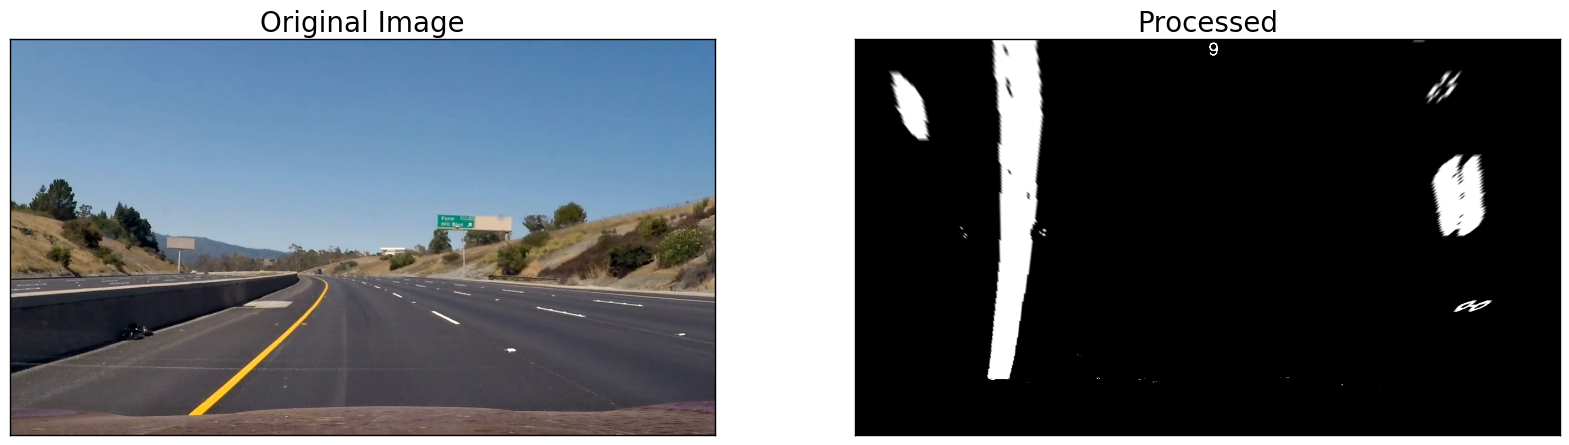

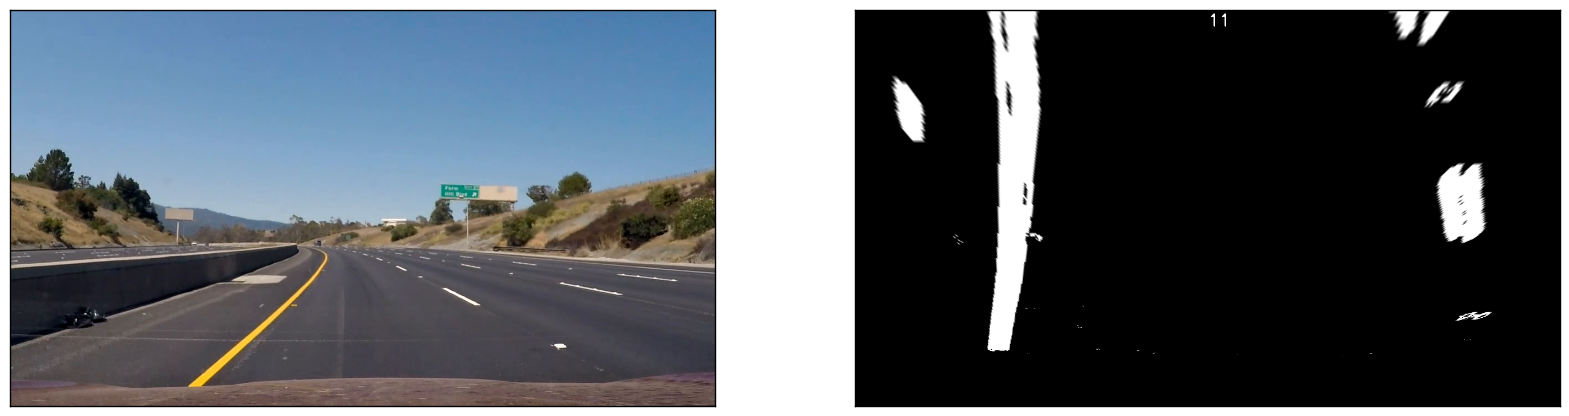

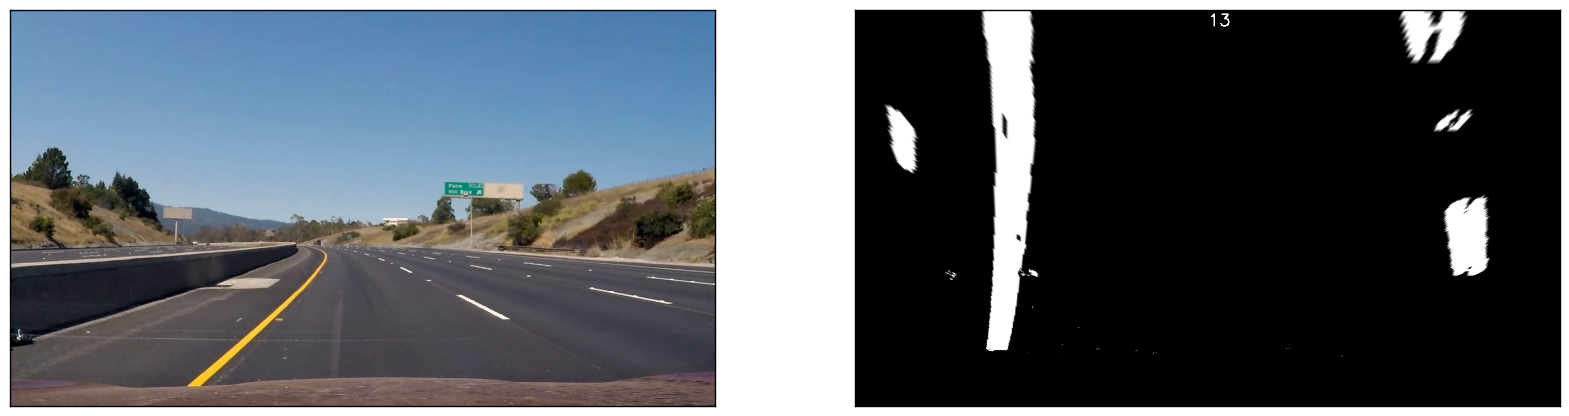

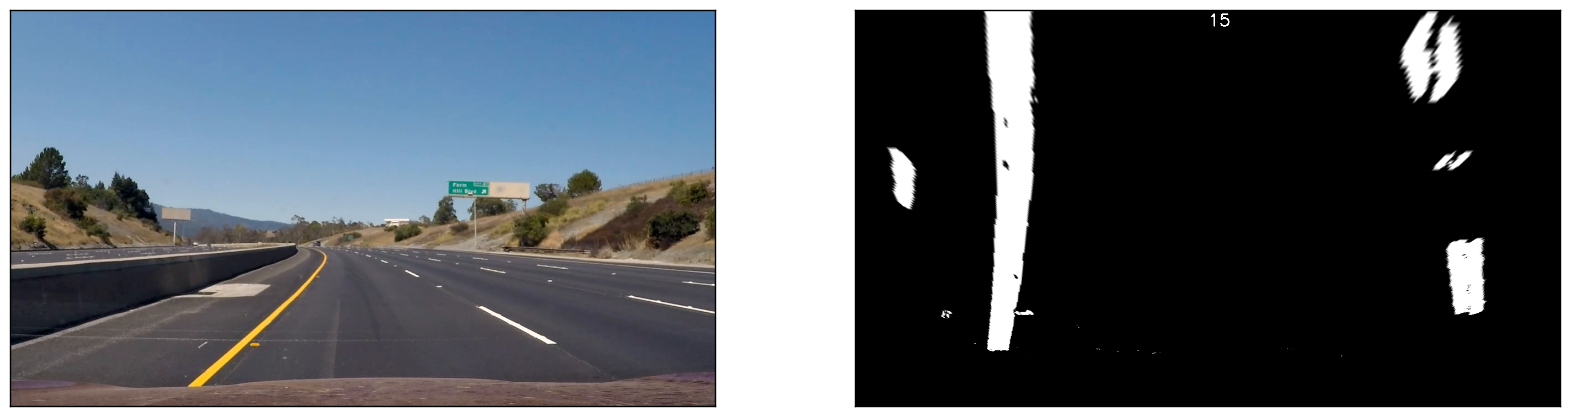

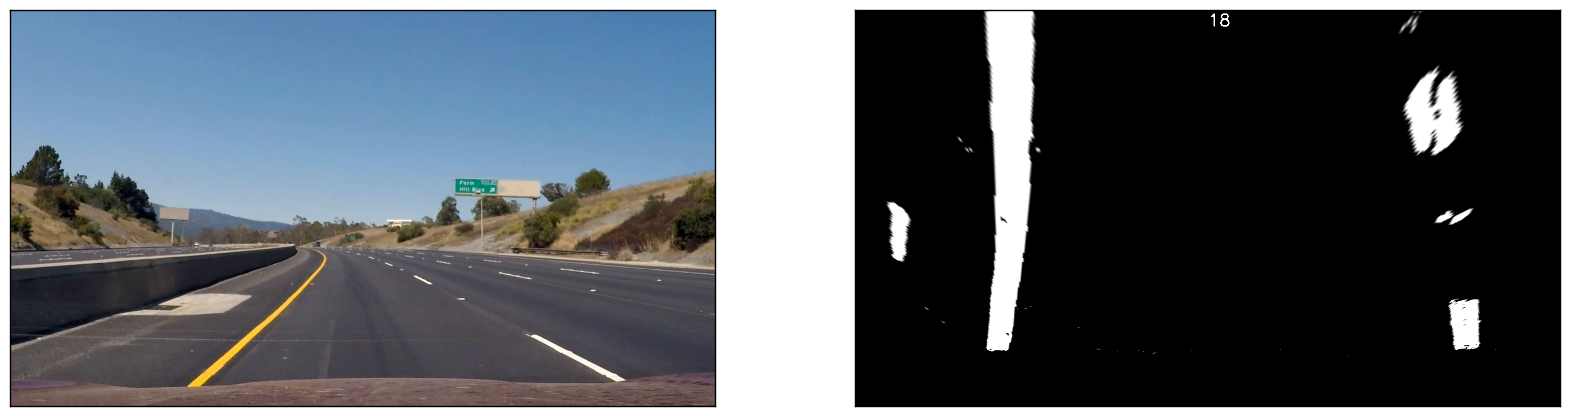

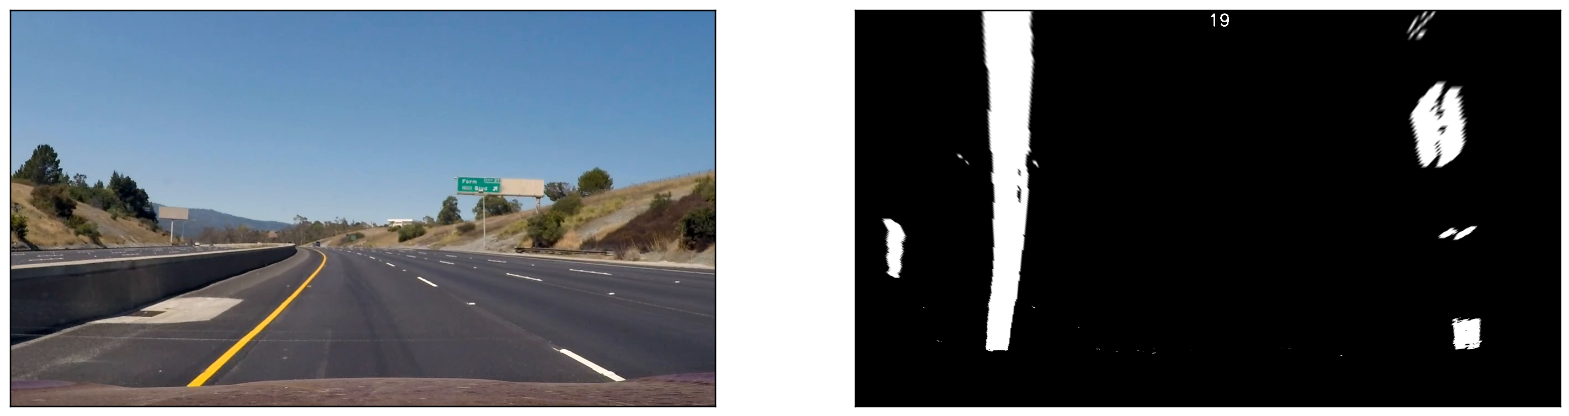

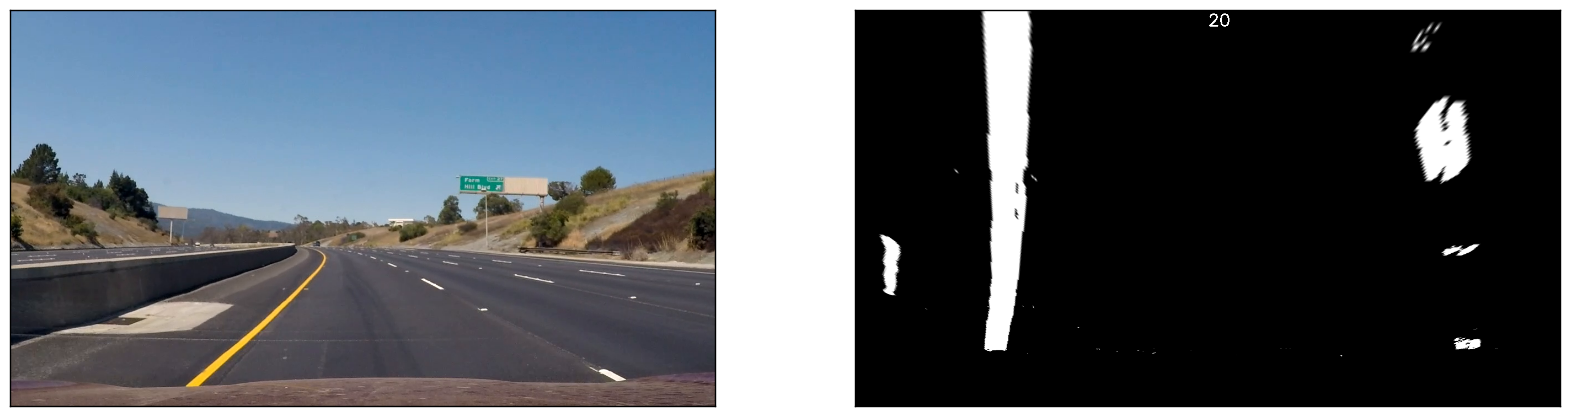

In [74]:
import cv2
import argparse
import numpy as np
import glob
import pickle
from moviepy.editor import VideoFileClip
from calibration import calculate_mtx_dist
from find_lines import *
import matplotlib.pyplot as plt
%matplotlib inline


video_file = 'project_video.mp4'
output_video_file = 'output.mp4'
mtx_dist_file = 'dist_pickle.p'
verbose = True


print("Video file: {}".format(video_file))
print("Output video file: {}".format(output_video_file))
print("Mtx/Dist file: {}".format(mtx_dist_file))
print("Verbose: {}".format(verbose))

print("Find lane lines ...")

# Load Saved Camera Matrix and Distortion Coefficients
dist_pickle = pickle.load(open(mtx_dist_file, "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

if verbose:
    print('mtx=',mtx)
    print('dist=',dist)


def sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # print(sobel)
    
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # print(sobel_abs)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # print(sobel_scaled)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    msk = np.zeros_like(sobel_scaled)
    msk[(sobel_scaled > thresh[0]) & (sobel_scaled < thresh[1]) ] = 1
    # print(msk)
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(msk) # Remove this line
#     return binary_output
    return binary_output

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_magn = np.sqrt(sobelx * sobelx + sobely * sobely)
    
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scaled = np.uint8(255*sobel_magn/np.max(sobel_magn))
    
    # 6) Create a binary mask where mag thresholds are met
    msk = np.zeros_like(sobel_scaled)
    msk[(sobel_scaled > mag_thresh[0]) & (sobel_scaled < mag_thresh[1]) ] = 1
    
    # 7) Return this mask as your binary_output image
    binary_output = np.copy(msk) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir1 = np.arctan2(abs_sobely, abs_sobelx)
#     print(dir1)
    # 5) Create a binary mask where direction thresholds are met
    msk = np.uint8(np.zeros_like(dir1))
    msk[(dir1 >= thresh[0]) & (dir1 <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(msk) # Remove this line
    return binary_output

# Thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    bin = np.zeros_like(S)
    bin[(S > thresh[0]) & (S <= thresh[1])] = 1
    return bin


    
class LineFinder(object):
    def __init__(self, mtx, dist, sampling=0.1):
        self.counter = 0
        self.mtx = mtx
        self.dist = dist
        self.sampling = sampling
        self.samples_orig = []
        self.samples_proc = []
    def process_image(self, image):
        img = np.copy(image)
        
        sampled = True if np.random.uniform() < self.sampling else False
        if sampled:
            self.samples_orig.append(image)
        
        # Frame size
        w, h = image.shape[1], image.shape[0]

        # Undistort
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        ksize = 31 # 31
        thresh_sobel = (50, 150) # (50, 120)
        thresh_mag = (50, 255) # (50, 120)
        thresh_dir = (0.75, 1.15) # (50, 120)
        
        # Gradient, Magnitude, Direction Thresholds
        gradx = sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=thresh_sobel)
#         grady = sobel_threshold(img, orient='y', sobel_kernel=ksize, thresh=thresh_sobel)
        mag_bin = mag_threshold(img, sobel_kernel=ksize, mag_thresh=thresh_mag)
        dir_bin = dir_threshold(img, sobel_kernel=ksize, thresh=thresh_dir)

        # Combine Thresholds
        comb_bin = np.zeros_like(gradx)
        comb_bin[(gradx == 1) | ((dir_bin == 1) & (mag_bin == 1))] = 1
#         comb_bin[((gradx == 1) & (grady == 1) & (dir_bin == 1)) | (mag_bin == 1)] = 1

#         cb = dir_bin
#         if sampled:
#         print('comb_bin =', cb)
        
        img_combined = cv2.cvtColor(comb_bin*255, cv2.COLOR_GRAY2RGB)
        
        # Color Threshold
        thresh_s = (170, 255)
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)        
        img_color = hls[:,:,2]
    
        color_bin = np.zeros_like(img_color)
        color_bin[(img_color > thresh_s[0]) & (img_color <= thresh_s[1])] = 1
        
        # Combined Gradient + Color
        combined = np.zeros_like(comb_bin)
        combined[(comb_bin == 1) | (color_bin == 1)] = 1
        
        img = cv2.cvtColor(combined*255, cv2.COLOR_GRAY2RGB)
        
#         img = img_combined
        
        # Perspective Transform
        PARAMS_DELTA_LEFT_BOTTOM = (160, -20) # (130, 60)
        PARAMS_DELTA_LEFT_UP = (-130, 120) # (-10, 30)
        PARAMS_DELTA_RIGHT_UP = (120, 120) # (10, 30)
        PARAMS_DELTA_RIGHT_BOTTOM = (-60, -20) # (-80, -60)
        region_deltas = [PARAMS_DELTA_LEFT_BOTTOM, PARAMS_DELTA_LEFT_UP, PARAMS_DELTA_RIGHT_UP, PARAMS_DELTA_RIGHT_BOTTOM]

        region_vertices = np.array([[(0      + region_deltas[0][0], h    + region_deltas[0][1]),
                             (w//2 + region_deltas[1][0], h//2 + region_deltas[1][1]),
                             (w//2 + region_deltas[2][0], h//2 + region_deltas[2][1]),
                             (w    + region_deltas[3][0], h    + region_deltas[3][1])]])
        
#         print('reg.shape =', region_vertices.shape)
        
        dest_vertices = np.array([[region_vertices[0][0],
                        (region_vertices[0][0][0],region_vertices[0][1][1]),
                        (region_vertices[0][3][0],region_vertices[0][2][1]),
                        region_vertices[0][3]]])
        offset = 100
        dest_vertices = np.array([[(offset, h - offset),
                        (offset, offset),
                        (w - offset, offset),
                        (w - offset, h - offset)]])
#         if sampled:
#             print('region_vertices =', region_vertices)
#             print('dest_vertices =', dest_vertices)

        M = cv2.getPerspectiveTransform(np.float32(region_vertices), np.float32(dest_vertices))
        img = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
            
#         cv2.polylines(img, region_vertices, True, (0, 0, 255), 5)    
#         cv2.polylines(img, dest_vertices, True, (0, 255, 0), 2)
        
        # Add Frame number
        cv2.putText(img, "{}".format(self.counter), (int(w/2), 30), cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], 2)
        
        if sampled:
            self.samples_proc.append(img)
        

        # Increase frame counter
        self.counter += 1

        return img
    



clip = VideoFileClip(video_file)
clip = clip.subclip(t_end=1)
print('Duration: ', clip.duration)
lineFinder = LineFinder(mtx=mtx, dist=dist, sampling=6./(clip.duration * 25))
clip = clip.fl_image(lineFinder.process_image)
clip.write_videofile(output_video_file, audio=False)

# img = cv2.imread('test_images/solidYellowLeft.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# lineFinder = LineFinder(mtx=mtx, dist=dist, sampling=1.0)
# lineFinder.process_image(img)

print('len(lineFinder) =', len(lineFinder.samples_orig))


for idx, (sample_orig, sample_proc) in enumerate(zip(lineFinder.samples_orig, lineFinder.samples_proc)):
#     print('idx=', idx)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])
    if idx == 0:
        plt.title('Original Image', fontsize=20)
    plt.imshow(sample_orig)
    plt.subplot(1, 2, 2)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])
    if idx == 0:
        plt.title('Processed', fontsize=20)
    plt.imshow(sample_proc)



In [75]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_file))

